# **Can you predict the Number of Likes a Youtube Video will get ?**

As YouTube becomes one of the most popular video-sharing platforms, YouTuber is developed as a new type of career in recent decades. YouTubers earn money through advertising revenue from YouTube videos, sponsorships from companies, merchandise sales, and donations from their fans. In order to maintain a stable income, the popularity of videos become the top priority for YouTubers. Meanwhile, some of our friends are YouTubers or channel owners in other video-sharing platforms. This raises our interest in predicting the performance of the video. If creators can have a preliminary prediction and understanding on their videos’ performance, they may adjust their video to gain the most attention from the public.

So here we have been provided with few details on videos along with some features as well.

 **Accurately predicting the number of likes for each video using the set of input variables is our Problem statement.**

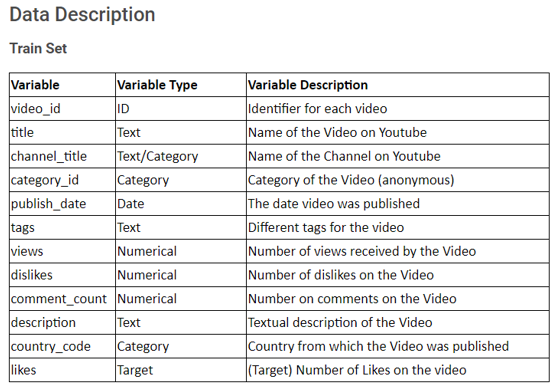

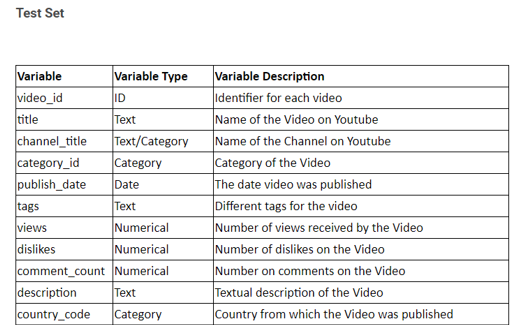

**Hypothesis Generation**

Simply put, a hypothesis is a possible view or assertion of an analyst about the problem he or she is working upon. It may be true or may not be true.

* Do videos with more views get more likes ?
* Do videos with more comments get more likes ?
* Do with videos with more dislikes get less likes ?
* Do longer videos get more likes than shorter videos ?
* Do descriptive videos get more number of likes ?
* Does a channel affect the number of likes?
* Does the country of origin affect the number of likes ?
* Do people post more videos on weekends than weekdays ?

# **Importing required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

# **Uploading the data**

In [2]:
from google.colab import files
files.upload()

Saving hacklive2_AV_Dataset.zip to hacklive2_AV_Dataset.zip


In [3]:
import os
cwd=os.getcwd()
print('cwd:',cwd)

cwd: /content


In [4]:
!unzip hacklive2_AV_Dataset.zip -d hacklive2_AV_Dataset

Archive:  hacklive2_AV_Dataset.zip
  inflating: hacklive2_AV_Dataset/hacklive2_AV_Dataset/sample_submission_cxCGjdN.csv  
  inflating: hacklive2_AV_Dataset/hacklive2_AV_Dataset/test.csv  
  inflating: hacklive2_AV_Dataset/hacklive2_AV_Dataset/train.csv  


In [5]:
!pip install -q --upgrade seaborn

In [6]:
os.chdir('/content/hacklive2_AV_Dataset/hacklive2_AV_Dataset')
cwd=os.getcwd()
print("cwd:",cwd)

cwd: /content/hacklive2_AV_Dataset/hacklive2_AV_Dataset


In [7]:
ss = pd.read_csv('sample_submission_cxCGjdN.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# **EDA**

**1. Brief look at the dataset.**

In [8]:
train.head(3)
test.head(3)

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,country_code,likes
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,24.0,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",351430.0,298.0,900.0,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,CA,2351.0
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,ABS-CBN Entertainment,24.0,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",461508.0,74.0,314.0,Vice Ganda notices Bela Padilla's sudden chang...,CA,3264.0
2,1856,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n ಕ್...,SANDALWOOD REVIEWS,24.0,2018-03-26,"challenging star darshan latest news|""challeng...",40205.0,150.0,100.0,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ ಕ್ಲ...,IN,580.0


,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,country_code
0,87185,జనవరి 31 గ్రహణం రోజు కొడుకులు ఉన్నవాళ్లు ఏం చే...,CHIRRAVURI FOUNDATION,22.0,2018-01-17,"Chirravuri|""Foundation""|""chirravuri foundation...",80793.0,54.0,79.0,8885569579...CHIRRAVURI FOUNDATION.\n\n☛Subsct...,IN
1,9431,ठाणे:'जेव्हा सत्ता बदलेल तेव्हा केस तुमच्यावरह...,VIRAL IN INDIA,22.0,2017-11-18,"Raj Thackeray|""LIVE SPEECH""|""latest Speech""|""r...",150317.0,230.0,311.0,Don't Forget to SUBSCIRBE to our YouTube Chann...,IN
2,40599,"Thank you, Rider Nation!",Saskatchewan Roughriders,17.0,2017-12-01,"Roughriders|""Riders""|""CFL""|""Regina""|""Saskatche...",6558.0,10.0,7.0,"“To the devoted, the impassioned, the loyal:\n...",CA


In [9]:
ID_COL, TARGET_COL = 'video_id', 'likes'

# **2. Dataset Shape (Number of Samples and Variables in the dataset)**

In [ ]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 26061 samples and 12 variables

Test contains 11170 samples and 11 variables

The dataset contains 10 features


# **3.Target Distribution**

This is a **regression problem**. Let's look the at the 'likes' distribution.

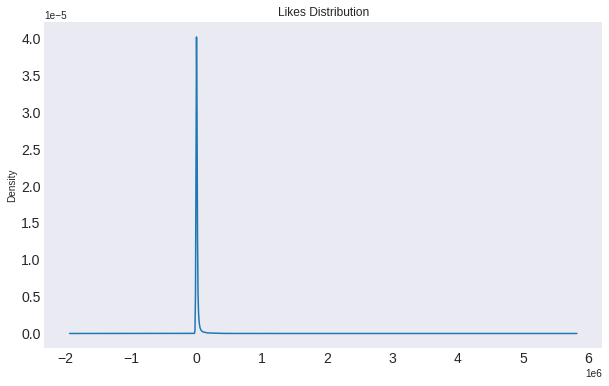

In [ ]:
_ = train[TARGET_COL].plot(kind = 'density', title = 'Likes Distribution', fontsize=14, figsize=(10, 6))

**Question**


***Highly Right Skewed Data.***

What can we do to change this distribution and make it more normal ?

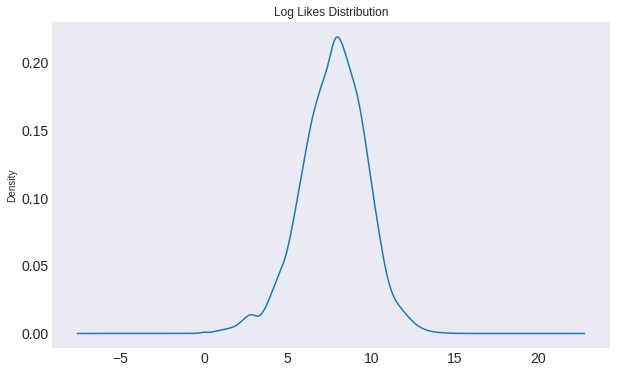

In [ ]:
_ = pd.Series(np.log1p(train[TARGET_COL])).plot(kind = 'density', title = 'Log Likes Distribution', fontsize=14, figsize=(10, 6))

Let's the see the same for boxplot.

1. Without log-transformation.
2. With log-transformation.


# **Original Target**

**Without log-transformation**

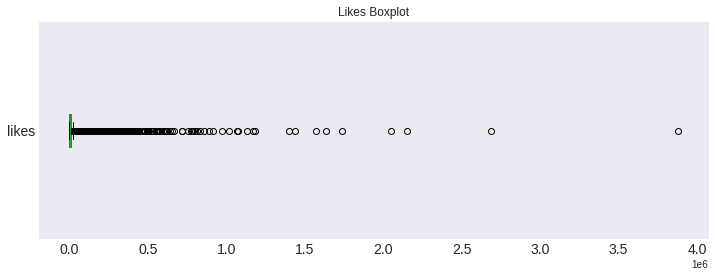

In [ ]:
_ = train[TARGET_COL].plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Likes Boxplot', fontsize=14)

**With log-transformation**

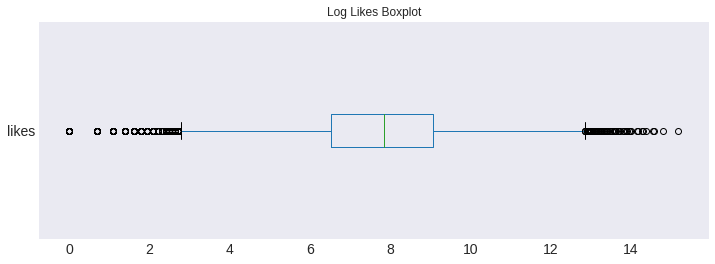

In [ ]:
_ = pd.Series(np.log1p(train[TARGET_COL])).plot(kind = 'box',
                                                vert=False,
                                                figsize=(12, 4),
                                                title = 'Log Likes Boxplot',
                                                fontsize=14)

# **4. Variable Datatypes**

Lets have a look at the kind of data types that is being used to store the variables in pandas.

pandas info() method on dataframe allows to do that. For each variable we can see the number of non-null values along with their datatypes.

In [ ]:
train.head(1)

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,country_code,likes
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,24.0,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",351430.0,298.0,900.0,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,CA,2351.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       26061 non-null  int64  
 1   title          26061 non-null  object 
 2   channel_title  26061 non-null  object 
 3   category_id    26061 non-null  float64
 4   publish_date   26061 non-null  object 
 5   tags           26061 non-null  object 
 6   views          26061 non-null  float64
 7   dislikes       26061 non-null  float64
 8   comment_count  26061 non-null  float64
 9   description    26061 non-null  object 
 10  country_code   26061 non-null  object 
 11  likes          26061 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ MB


Looks like we have a mixture of datatypes, a lot of these variables are object datatypes. Object datatypes are used to store strings along with other non-numeric data. This is obvious since we encountered a lot of strings when we had a look at the dataset.

Machine Learning Models understand only numbers so we will have to later convert these strings to numbers

# **5. Null Values**

Although the info() function did tell us about non-null values ideally we want to have a look at the percentage of null values in each variable.

In [ ]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

likes            0.0
country_code     0.0
description      0.0
comment_count    0.0
dislikes         0.0
views            0.0
tags             0.0
publish_date     0.0
category_id      0.0
channel_title    0.0
title            0.0
video_id         0.0
dtype: float64

# **6. Unique values in each variable**

In [ ]:
train.nunique()

video_id         26061
title            26005
channel_title     5764
category_id         17
publish_date       348
tags             21462
views            25338
dislikes          2633
comment_count     4993
description      23426
country_code         4
likes            12134
dtype: int64

# **Analyzing Each Variable & their relationships**

There are 4 types of features that we have:

1. Numerical
2. Categorical
3. Textual
4. DateTime

Also our target is Continuous

For each feature type we will be perform two types of analysis:

1. **Univariate:** Analyze 1 feature at a time

2. **Bivariate:** Analyze the relationship of that feature with target variable, i.e. 'likes'

In [ ]:
train.columns

Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code', 'likes'],
      dtype='object')

**Numerical Variables**

In [10]:
num_cols = ['views', 'dislikes', 'comment_count']

***Univariate Analyis***

**Log Transformation of Numerical Columns**

*Density Plots*

In [ ]:
for c in num_cols + ['likes']:
  train[c] = np.log1p(train[c]) 

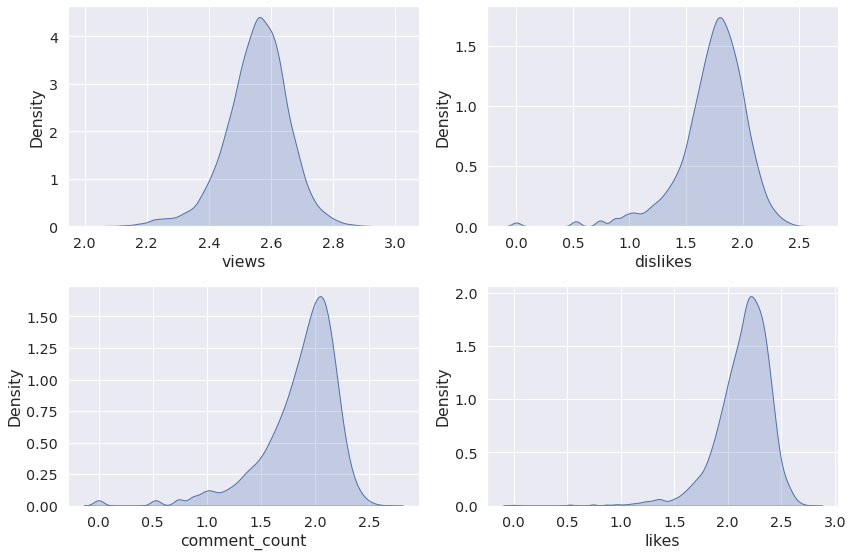

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols + ['likes']):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

**Bivariate Analysis (for numerical columns)**

***Correlation HeatMaps (for numerical columns)***

<Figure size 576x360 with 0 Axes>

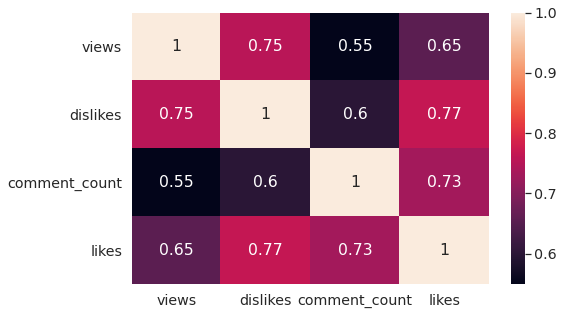

In [ ]:
plt.figure(figsize=(8, 5))
_ = sns.heatmap(train[num_cols + ['likes']].corr(), annot=True)

**Answering Hypothesis**


**1. Do videos with more views get more likes ?**

Yes they do, we have a high correlation of 0.72 also the plot between the two variables shows this.

**2. Do videos with more comments get more likes ?**

Yes they do, we have a high correlation of 0.82 also the plot between the two variables shows this.

**3. Do videos with more dislikes get less likes ?**

Any form of popularity is good popularity. As the number dislikes increases, number of views increases too, and so the number of likes.

**4. Do longer videos get more likes than shorter videos ?**

We don't have data to answer this question. 
Should we try to collect more data ? 
What other features could be helpful ?

# **Categorical Variables**

In the same way we will do univariate and Bi-variate analysis of Categorical variables

**Univariate Analysis**

***Pie Charts***

In [ ]:
train.columns

Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code', 'likes'],
      dtype='object')

In [ ]:
train['channel_title'].nunique()

5764

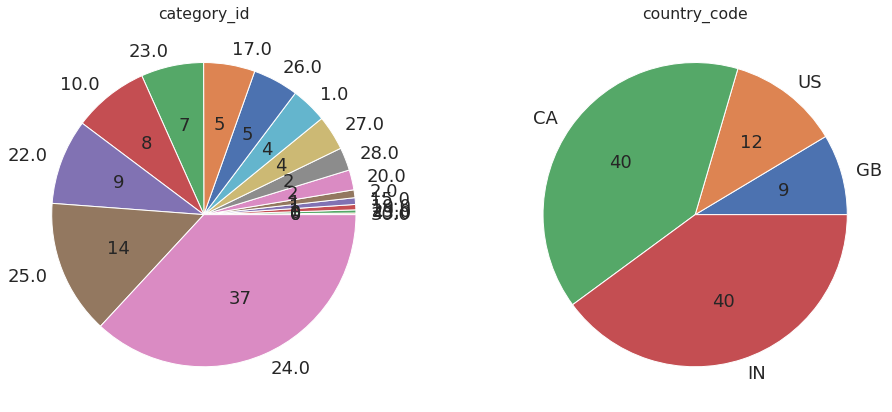

In [ ]:
cat_cols = ['category_id', 'country_code', 'channel_title']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, c in enumerate(['category_id', 'country_code']):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=18)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

**Horizontal Bar Plots**

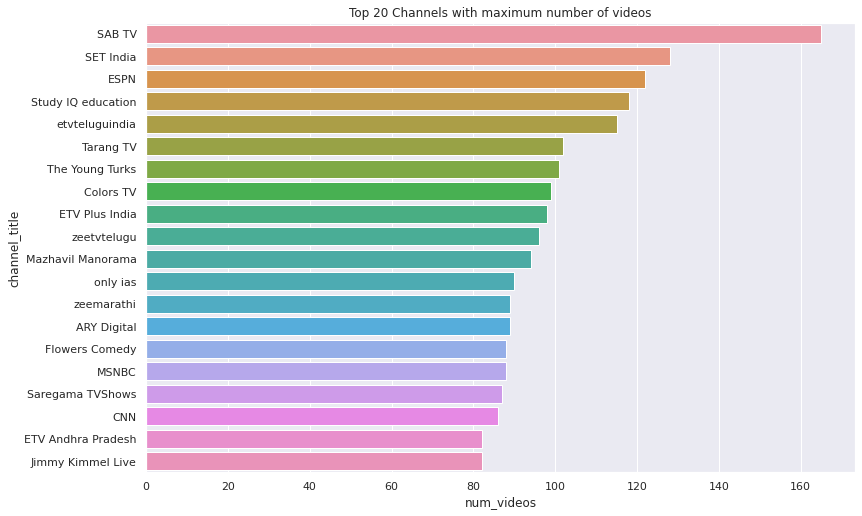

In [ ]:
sns.set(rc={'figure.figsize':(12.7, 8.27)})

top_20_channels = train['channel_title'].value_counts()[:20].reset_index()
top_20_channels.columns = ['channel_title', 'num_videos']

_ = sns.barplot(data = top_20_channels, y = 'channel_title', x = 'num_videos')
_ = plt.title("Top 20 Channels with maximum number of videos")

**Bivariate Analyis**

**Country Wise Number of Videos for Channel**

In [ ]:
country_wise_channels = train.groupby(['country_code', 'channel_title']).size().reset_index()
country_wise_channels.columns = ['country_code', 'channel_title', 'num_videos']
country_wise_channels = country_wise_channels.sort_values(by = 'num_videos', ascending=False)

In [ ]:
country_wise_channels

,country_code,channel_title,num_videos
4937,IN,Study IQ education,118
5237,IN,etvteluguindia,115
5016,IN,Tarang TV,102
2220,CA,The Young Turks,100
4254,IN,Colors TV,99
...,...,...,...
2890,GB,All Time Low,1
2889,GB,Alissa Ashley,1
2888,GB,Ali-A,1
2886,GB,Alesso,1


**Fetching Top 10 channels for each country**

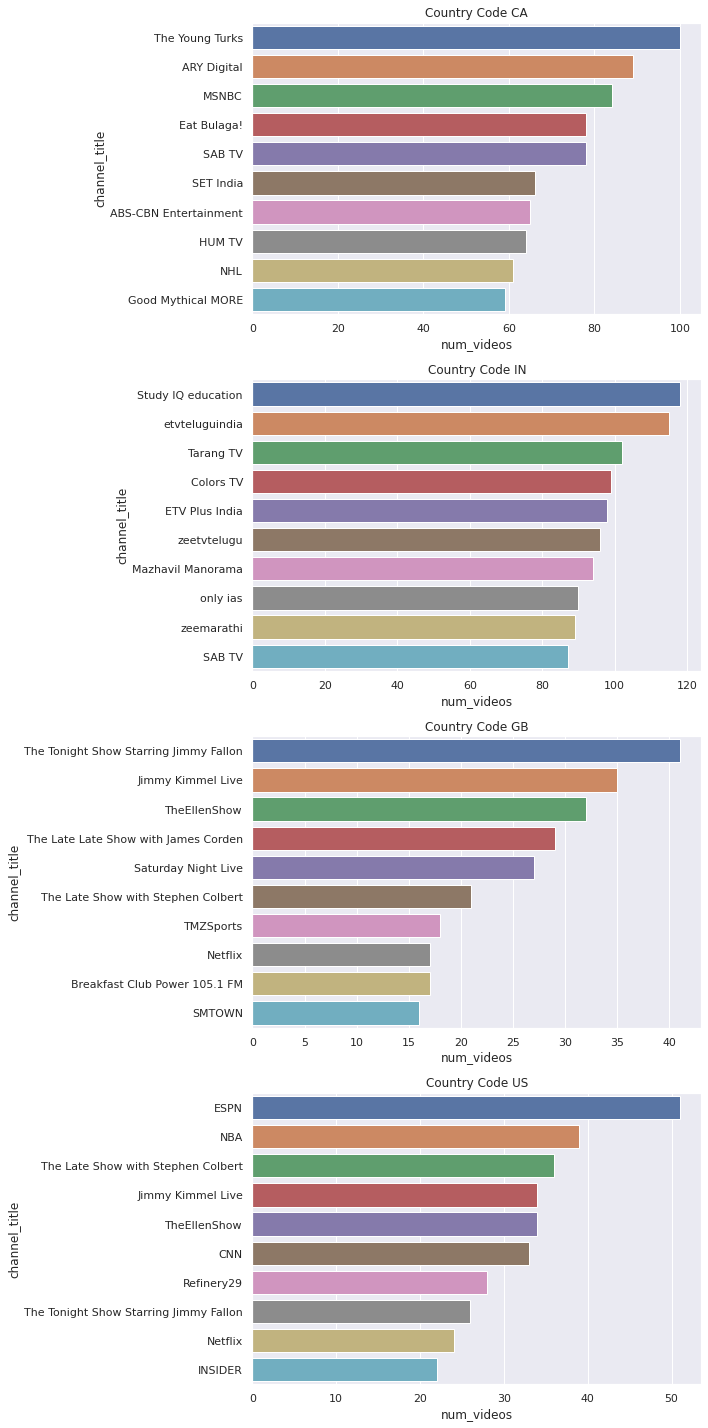

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'num_videos', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

**Multivariate Analysis**

Analyzing more than two variables at once

**Country Wise Likes for Channel**

What are the variables that we want to analyze here ?

In [ ]:
country_wise_channels = train.groupby(['country_code', 'channel_title'])['likes'].max().reset_index()
country_wise_channels = country_wise_channels.sort_values(by = ['likes'], ascending=False)

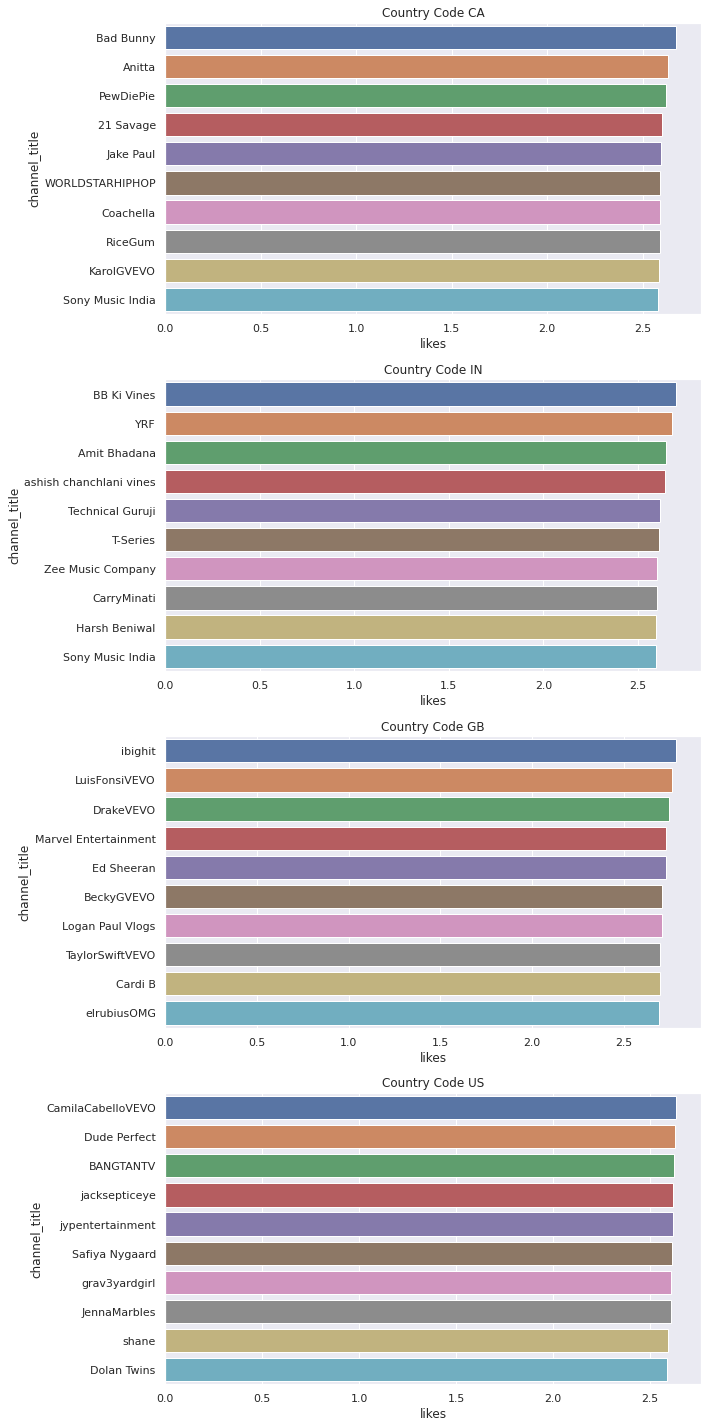

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'likes', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

**Mean Likes Per Country**

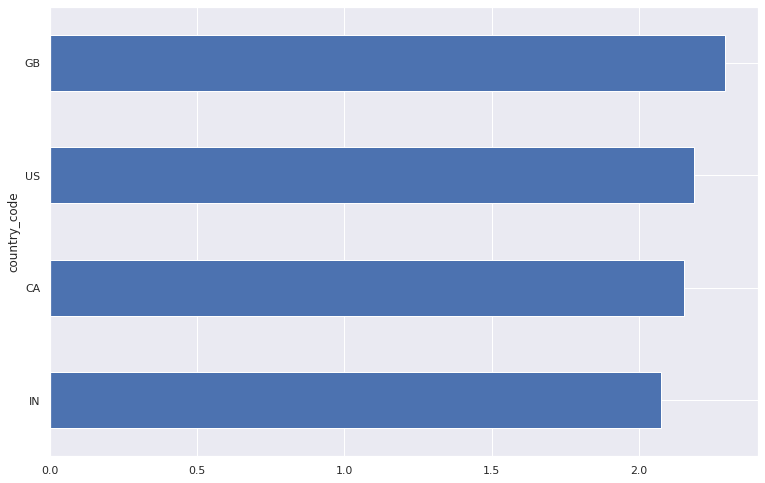

In [ ]:
_ = train.groupby('country_code')['likes'].mean().sort_values().plot(kind = 'barh')

**Question**

Does a country affect the number of likes?

Looks like videos posted in England have an higher average number of likes compared to videos posted in India.

# **DateTime Variables**

In [ ]:
train['publish_date'] = pd.to_datetime(train['publish_date'], format='%Y-%m-%d')
test['publish_date'] = pd.to_datetime(test['publish_date'], format='%Y-%m-%d')
train['publish_date']

0       2017-12-12
1       2018-03-08
2       2018-03-26
3       2018-02-21
4       2018-05-10
           ...    
26056   2018-01-16
26057   2017-12-17
26058   2018-03-04
26059   2018-05-17
26060   2018-01-16
Name: publish_date, Length: 26061, dtype: datetime64[ns]

**Value Counts of Videos Year Wise**

**Mininum and Maximum Date**

In [ ]:
train['publish_date'].min(), train['publish_date'].max()

(Timestamp('2006-07-23 00:00:00'), Timestamp('2018-06-14 00:00:00'))

In [ ]:
train['publish_date'].dt.year.value_counts()

2018    18841
2017     7132
2015       16
2016       16
2011       13
2014        9
2013        9
2009        8
2012        6
2010        4
2008        3
2007        3
2006        1
Name: publish_date, dtype: int64

**Number of Videos in Data datewise**

From the above information we see that no of videos are more after 2017. Lets see the pattern here.

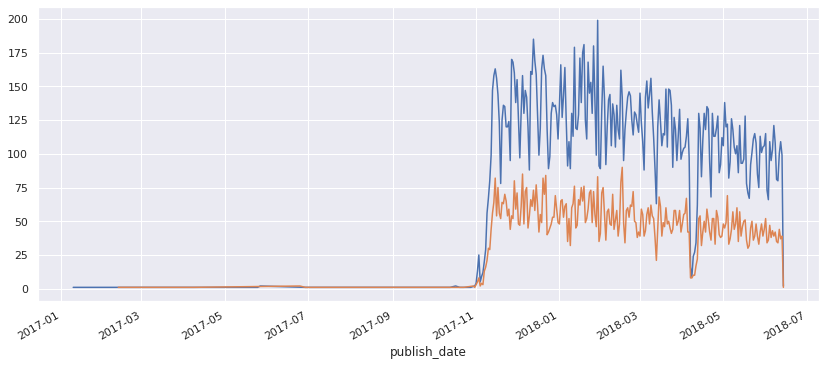

In [ ]:
latest_data_train = train[train['publish_date'] > '2017']
latest_data_test = test[test['publish_date'] > '2017']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(14, 6))
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(14, 6))

Lets dive even deeper to check the trend/pattern after 2017-11 (Nov)

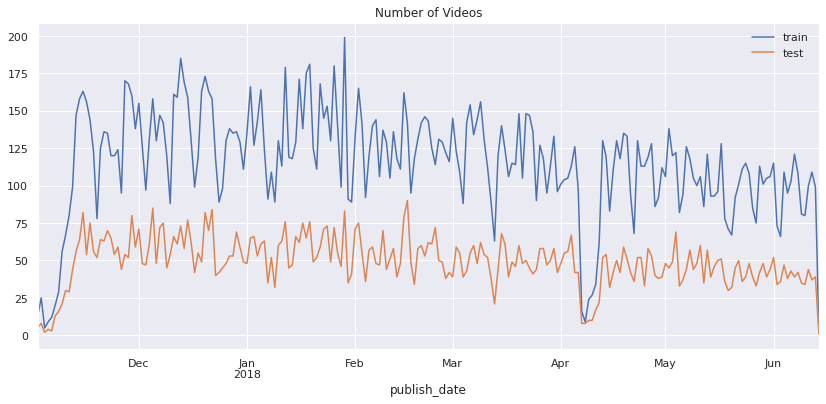

In [ ]:
latest_data_train = train[train['publish_date'] > '2017-11']
latest_data_test = test[test['publish_date'] > '2017-11']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().rename('train').plot(figsize=(14, 6), title = 'Number of Videos')
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().rename('test').plot(figsize=(14, 6), title = 'Number of Videos')
_ = plt.legend()

**Lets Dissect the data even more by comparing against each country**

**Mean Number of Likes by Country sorted by Date**

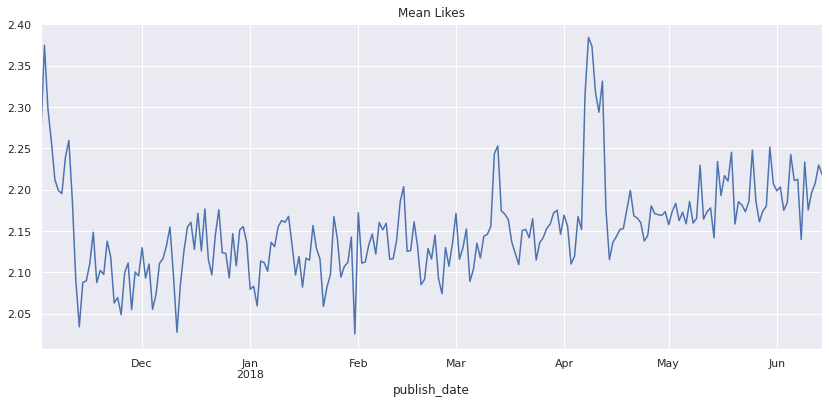

In [ ]:
latest_data = train[train['publish_date'] > '2017-11']
_ = latest_data.sort_values(by = 'publish_date').groupby('publish_date')['likes'].mean().plot(figsize=(14, 6), title="Mean Likes")

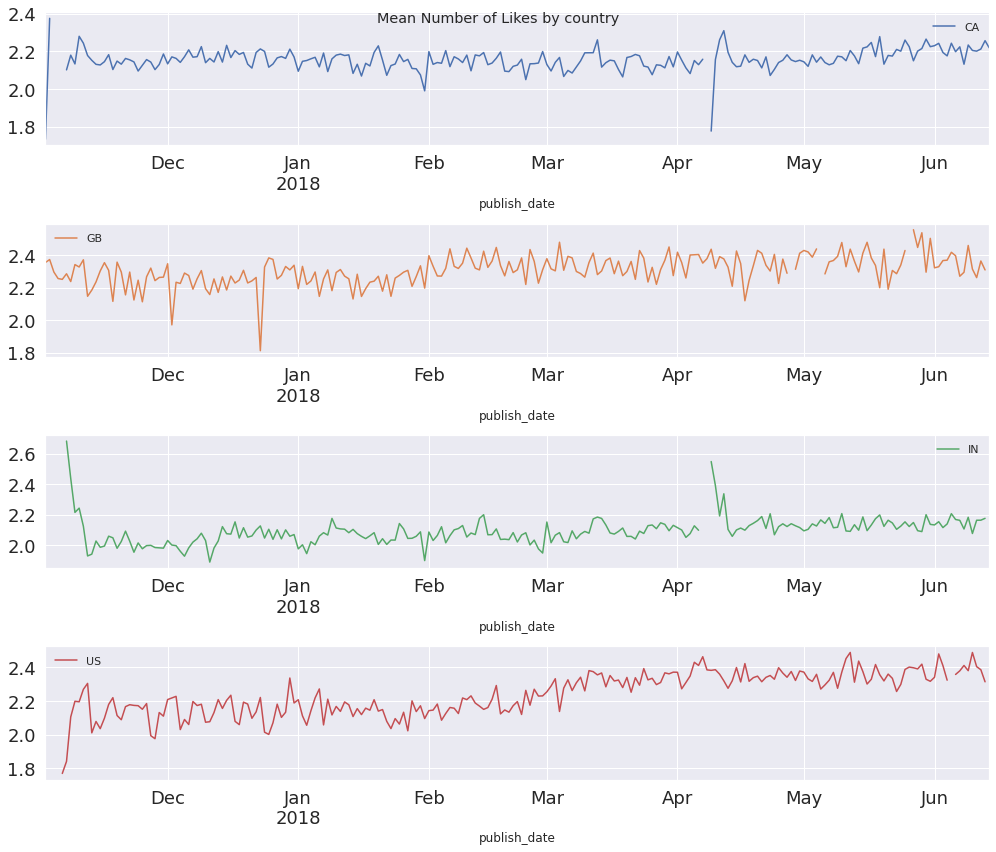

In [ ]:
tmp = latest_data.groupby(['publish_date', 'country_code'])['likes'].mean().reset_index()
_ = tmp.pivot_table(index = 'publish_date', columns = 'country_code', values='likes').plot(subplots=True, figsize=(14, 12),
                                                                                           title='Mean Number of Likes by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

**Do people post more videos on weekends than weekdays ?**

In [ ]:
train['dayofweek'] = train['publish_date'].dt.dayofweek

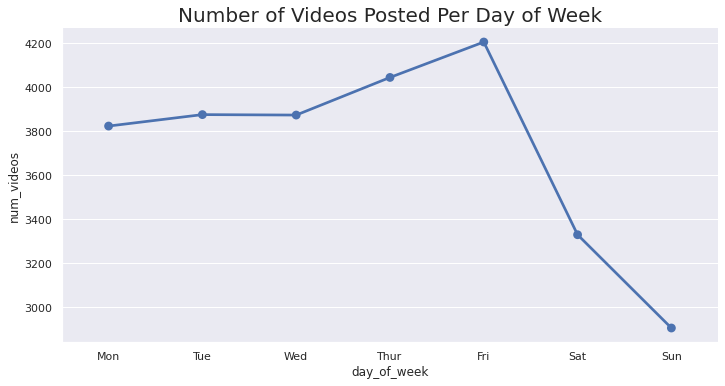

In [ ]:
n_videos_per_day_of_week = train['dayofweek'].value_counts().sort_index().reset_index()
n_videos_per_day_of_week.columns = ['day_of_week', 'num_videos']
n_videos_per_day_of_week['day_of_week'] = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
_ = sns.catplot(x = 'day_of_week', y = 'num_videos', data = n_videos_per_day_of_week, kind = 'point',aspect = 12/6)
_ = plt.title("Number of Videos Posted Per Day of Week", fontsize=20)

It looks our hypothesis is incorrect in context of the current data. Most of the videos were published on Friday, but Saturday and Sunday saw the least number of videos published

# **Textual Data**

In [11]:
text_cols = ['title', 'tags', 'description']

**Do descriptive videos get more number of likes ?**

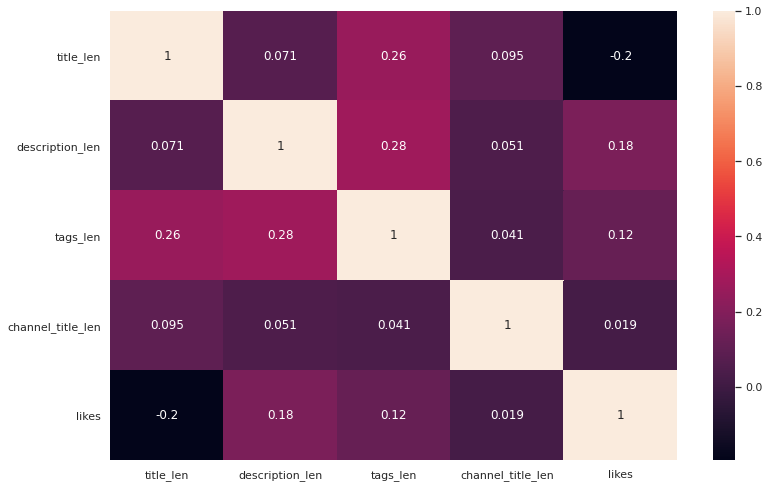

In [ ]:
train['title_len'] = train['title'].apply(lambda x: len(x))
train['description_len'] = train['description'].apply(lambda x: len(x))
train['tags_len'] = train['tags'].apply(lambda x: len(x))
train['channel_title_len'] = train['channel_title'].apply(lambda x: len(x))

_  = sns.heatmap(train[['title_len', 'description_len', 'tags_len', 'channel_title_len', 'likes']].corr(), annot = True)

**Answer: So if you keep your title length short and description long, you are having higher chances of getting likes.**

# **Defining the Metric for Regression Model**

# **METRIC**

**RMSLE(Root Mean Squared Log Error)**

Simply put RMSLE is the Root Mean Squared Error of the logarithm of actual and predicted values.

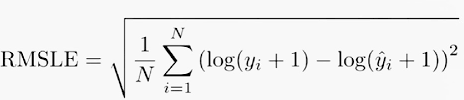

The Robustness of RMSLE to the outliers, the property of calculating the relative error between the Predicted and Actual Values, the most unique property of the RMLSE that it penalizes the underestimation of the actual value more severely than it does for the Overestimation.

**Read More about RMSLE here**

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064

https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-

**Importing required Libraries and defining help functions**

In [ ]:
pip install catboost --no-cache-dir

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [14]:
def download_preds(preds_test, file_name = 'submission.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

In [15]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

# **MODEL BUILDING**

**1. Adding Numerical Columns and Predicting using Linear Regression**

In [78]:
ss = pd.read_csv('sample_submission_cxCGjdN.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [79]:
ID_COL, TARGET_COL = 'video_id', 'likes'

num_cols = ['views', 'dislikes', 'comment_count']
cat_cols = ['category_id', 'country_code']
text_cols = ['title', 'channel_title', 'tags', 'description']
date_cols = ['publish_date']

In [80]:
train.shape, test.shape

((26061, 12), (11170, 11))

In [81]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)
df.shape

(37231, 12)

In [82]:
df = pd.get_dummies(df, columns = cat_cols)

In [83]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

In [84]:
df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

In [23]:
df['likes']

0         7.763021
1         8.091015
2         6.364751
3        11.323869
4         8.176954
           ...    
37226          NaN
37227          NaN
37228          NaN
37229          NaN
37230          NaN
Name: likes, Length: 37231, dtype: float64

In [85]:
df.head(2)

,video_id,title,channel_title,publish_date,tags,views,dislikes,comment_count,description,likes,category_id_1.0,category_id_2.0,category_id_10.0,category_id_15.0,category_id_17.0,category_id_19.0,category_id_20.0,category_id_22.0,category_id_23.0,category_id_24.0,category_id_25.0,category_id_26.0,category_id_27.0,category_id_28.0,category_id_29.0,category_id_30.0,category_id_43.0,country_code_CA,country_code_GB,country_code_IN,country_code_US
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",12.769769,5.700444,6.803505,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,7.763021,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,ABS-CBN Entertainment,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",13.042257,4.317488,5.752573,Vice Ganda notices Bela Padilla's sudden chang...,8.091015,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


**Splitting Train data into Train and Validation set and predicting on Test data**

In [86]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [87]:
trn, val = train_test_split(train_proc, test_size=0.2, random_state = 1)

###### Input to our model will be the features
X_trn, X_val = trn[features], val[features]

###### Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

##### Features for the test data that we will be predicting
X_test = test_proc[features]

***Building model using Linear Regression and predicting the no of likes using just numerical columns***

In [88]:
clf = LinearRegression()

_ = clf.fit(X_trn[num_cols], y_trn)

preds_val = clf.predict(X_val[num_cols])

rmsle_metric_score = rmsle_metric(y_val, preds_val)

print(f'rmsle metric score is: {rmsle_metric_score}')

rmsle metric score is: 949.5701548787257


In [ ]:
preds_test = clf.predict(X_test[num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('lr.csv')

,video_id,likes
0,87185,699.336920
1,9431,2703.969243
2,40599,61.167703
3,494,2068.652873
4,73942,1616.879332
...,...,...
11165,19415,2124.039869
11166,25168,3706.544106
11167,80293,5354.955513
11168,80880,20543.033487


In [89]:
X_trn.columns

Index(['title', 'channel_title', 'publish_date', 'tags', 'views', 'dislikes',
       'comment_count', 'description', 'category_id_1.0', 'category_id_2.0',
       'category_id_10.0', 'category_id_15.0', 'category_id_17.0',
       'category_id_19.0', 'category_id_20.0', 'category_id_22.0',
       'category_id_23.0', 'category_id_24.0', 'category_id_25.0',
       'category_id_26.0', 'category_id_27.0', 'category_id_28.0',
       'category_id_29.0', 'category_id_30.0', 'category_id_43.0',
       'country_code_CA', 'country_code_GB', 'country_code_IN',
       'country_code_US'],
      dtype='object')

In [90]:
features = [c for c in X_trn.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in text_cols + date_cols]

In [60]:
clf = LinearRegression()

_ = clf.fit(X_trn[cat_num_cols], y_trn)

preds_val = clf.predict(X_val[cat_num_cols])

rmsle_metric_score = rmsle_metric(y_val, preds_val)

print(f'rmsle metric score is: {rmsle_metric_score}')

rmsle metric score is: 873.0627392234118


In [ ]:
preds_test = clf.predict(X_test[cat_num_cols])

preds_test = np.expm1(preds_test)

download_preds(preds_test, 'lr_num_cat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('lr_num_cat.csv')

,video_id,likes
0,87185,619.274464
1,9431,2248.410381
2,40599,59.060247
3,494,3895.071896
4,73942,1438.234155
...,...,...
11165,19415,1878.938060
11166,25168,3850.642023
11167,80293,3957.385411
11168,80880,10859.721258


In [91]:
pd.qcut(np.arange(10), 5, labels = False, duplicates='drop')

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

In [92]:
from sklearn.model_selection import StratifiedKFold

In [93]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET_COL]
  #print('target:',target)

  folds = StratifiedKFold(n_splits = N_SPLITS)
  #print('folds:',folds)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')
  #print('stratified_target:',stratified_target)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')
    #print('train:',train)
    #print('stratified_target:',stratified_target)
    #print('folds.split(train, stratified_target):',folds.split(train, stratified_target))
    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]
    print('features:',features)
    print('trn_idx:',trn_idx)
    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]
    print('val_idx:',val_idx)
    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = rmsle_metric(y_val, preds_val)
    print(f'\nrmsle_metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    #print('oofs:',oofs)
    preds += preds_test / N_SPLITS
    #print('preds_test:',preds_test)
    #print('N_SPLITS:',N_SPLITS)
    #print('preds:',preds)


  oofs_score = rmsle_metric(target, oofs)
  print(f'\n\nrmsle_metric for oofs is {oofs_score}')

  return oofs, preds

In [94]:
dt_params = {'max_depth': 12,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

clf = DecisionTreeRegressor(**dt_params)
dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------
features: ['views', 'dislikes', 'comment_count', 'category_id_1.0', 'category_id_2.0', 'category_id_10.0', 'category_id_15.0', 'category_id_17.0', 'category_id_19.0', 'category_id_20.0', 'category_id_22.0', 'category_id_23.0', 'category_id_24.0', 'category_id_25.0', 'category_id_26.0', 'category_id_27.0', 'category_id_28.0', 'category_id_29.0', 'category_id_30.0', 'category_id_43.0', 'country_code_CA', 'country_code_GB', 'country_code_IN', 'country_code_US']
trn_idx: [ 4845  4853  4881 ... 26058 26059 26060]
val_idx: [   0    1    2 ... 5440 5444 5452]

rmsle_metric score for validation set is 773.4030825928064

------------- Fold 2 -------------
features: ['views', 'dislikes', 'comment_count', 'category_id_1.0', 'category_id_2.0', 'category_id_10.0', 'category_id_15.0', 'category_id_17.0', 'category_id_19.0', 'category_id_20.0', 'category_id_22.0', 'category_id_23.0', 'category_id_24.0', 'category_id_25.0', 'category_id_26.0', 'category_id_27.0', 'c

In [95]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()
  #print('feature_importances:',feature_importances)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]
    print('features:',features)
    print('trn_idx:',trn_idx)
    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]
    print('val_idx:',val_idx)
    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    #print('fold_importance:',fold_importance)
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)
    #print('feature_importances:',feature_importances)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = rmsle_metric(y_val, preds_val)
    print(f'\nrmsle_metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = rmsle_metric(target, oofs)
  print(f'\n\nrmsle_metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  #print('feature_importances:',feature_importances)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi


------------- Fold 1 -------------
features: ['views', 'dislikes', 'comment_count', 'category_id_1.0', 'category_id_2.0', 'category_id_10.0', 'category_id_15.0', 'category_id_17.0', 'category_id_19.0', 'category_id_20.0', 'category_id_22.0', 'category_id_23.0', 'category_id_24.0', 'category_id_25.0', 'category_id_26.0', 'category_id_27.0', 'category_id_28.0', 'category_id_29.0', 'category_id_30.0', 'category_id_43.0', 'country_code_CA', 'country_code_GB', 'country_code_IN', 'country_code_US']
trn_idx: [ 4845  4853  4881 ... 26058 26059 26060]
val_idx: [   0    1    2 ... 5440 5444 5452]
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.688058
[200]	valid_0's rmse: 0.673056
[300]	valid_0's rmse: 0.668448
[400]	valid_0's rmse: 0.666901
[500]	valid_0's rmse: 0.666187
[600]	valid_0's rmse: 0.666155
[700]	valid_0's rmse: 0.665891
[800]	valid_0's rmse: 0.666161
Early stopping, best iteration is:
[733]	valid_0's rmse: 0.665611

rmsle_metric score for vali

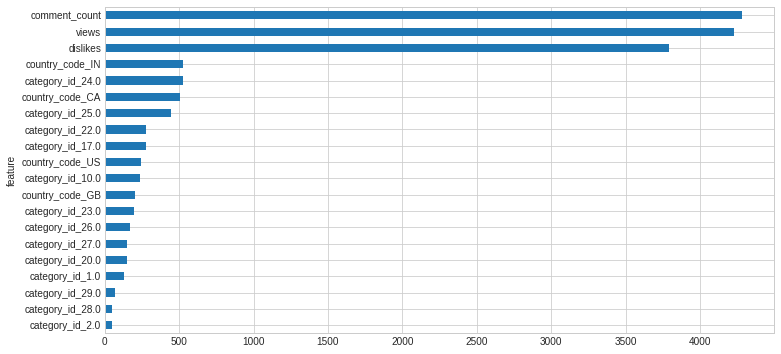

In [96]:
clf = LGBMRegressor(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

# **Adding Date Columns to the model and predicting**

In [125]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
  df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))
  df = pd.get_dummies(df, columns = cat_cols)
  df = df.fillna(-999)
  df.isnull().sum().sum()
  
  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

In [126]:
df, features = join_df(train, test)

In [127]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d')
df['publish_date_days_since_start'] = (df['publish_date'] - df['publish_date'].min()).dt.days

df['publish_date_day_of_week'] = df['publish_date'].dt.dayofweek
df['publish_date_year'] = df['publish_date'].dt.year
df['publish_date_month'] = df['publish_date'].dt.month

In [138]:
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_date_cols = [c for c in features if c not in ['title', 'tags', 'channel_title','description', 'publish_date']]

In [139]:
cat_num_date_cols

['views',
 'dislikes',
 'comment_count',
 'publish_date_days_since_start',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month',
 'category_id_1.0',
 'category_id_2.0',
 'category_id_10.0',
 'category_id_15.0',
 'category_id_17.0',
 'category_id_19.0',
 'category_id_20.0',
 'category_id_22.0',
 'category_id_23.0',
 'category_id_24.0',
 'category_id_25.0',
 'category_id_26.0',
 'category_id_27.0',
 'category_id_28.0',
 'category_id_29.0',
 'category_id_30.0',
 'category_id_43.0',
 'country_code_CA',
 'country_code_GB',
 'country_code_IN',
 'country_code_US']

In [140]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
features: ['views', 'dislikes', 'comment_count', 'publish_date_days_since_start', 'publish_date_day_of_week', 'publish_date_year', 'publish_date_month', 'category_id_1.0', 'category_id_2.0', 'category_id_10.0', 'category_id_15.0', 'category_id_17.0', 'category_id_19.0', 'category_id_20.0', 'category_id_22.0', 'category_id_23.0', 'category_id_24.0', 'category_id_25.0', 'category_id_26.0', 'category_id_27.0', 'category_id_28.0', 'category_id_29.0', 'category_id_30.0', 'category_id_43.0', 'country_code_CA', 'country_code_GB', 'country_code_IN', 'country_code_US']
trn_idx: [ 4845  4853  4881 ... 26058 26059 26060]
val_idx: [   0    1    2 ... 5440 5444 5452]
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.668603
[600]	valid_0's rmse: 0.664549
[900]	valid_0's rmse: 0.664192
Early stopping, best iteration is:
[971]	valid_0's rmse: 0.663848

rmsle_metric score for validation set is 663.8479305370959

------------- Fold

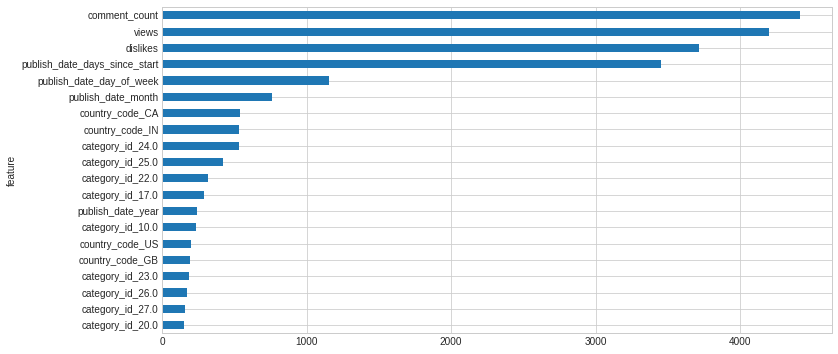

In [141]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_date_cols)

# **Adding Text columns to the Model and Predicting**

In [142]:
from sklearn.feature_extraction.text import CountVectorizer

In [143]:
TOP_N_WORDS = 50

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts = vec.fit_transform(df['description']).toarray()
txt_to_fts.shape

(37231, 50)

In [148]:
c = 'description'
txt_fts_names = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_names] = txt_to_fts

train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_date_text_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date','channel_title']]


------------- Fold 1 -------------
features: ['views', 'dislikes', 'comment_count', 'publish_date_days_since_start', 'publish_date_day_of_week', 'publish_date_year', 'publish_date_month', 'category_id_1.0', 'category_id_2.0', 'category_id_10.0', 'category_id_15.0', 'category_id_17.0', 'category_id_19.0', 'category_id_20.0', 'category_id_22.0', 'category_id_23.0', 'category_id_24.0', 'category_id_25.0', 'category_id_26.0', 'category_id_27.0', 'category_id_28.0', 'category_id_29.0', 'category_id_30.0', 'category_id_43.0', 'country_code_CA', 'country_code_GB', 'country_code_IN', 'country_code_US', 'description_word_0_count', 'description_word_1_count', 'description_word_2_count', 'description_word_3_count', 'description_word_4_count', 'description_word_5_count', 'description_word_6_count', 'description_word_7_count', 'description_word_8_count', 'description_word_9_count', 'description_word_10_count', 'description_word_11_count', 'description_word_12_count', 'description_word_13_count', '

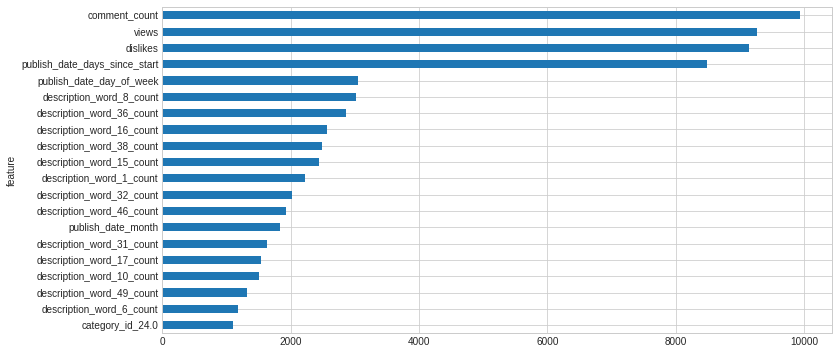

In [151]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_date_text_cols)

In [152]:
df['tags'] = df['tags'].apply(lambda x: x.strip().replace('|', ''))

In [153]:
TOP_N_WORDS = 20

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts_tags = vec.fit_transform(df['tags']).toarray()
txt_to_fts_tags.shape

(37231, 20)

In [154]:
c = 'tags'
txt_fts_names_tags = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_names_tags] = txt_to_fts_tags

In [155]:
TOP_N_WORDS = 25

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts_title = vec.fit_transform(df['title']).toarray()
txt_to_fts_title.shape

(37231, 25)

In [156]:
c = 'title'
txt_fts_names_title = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_names_title] = txt_to_fts_title

In [157]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_date_text_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date','channel_title']]


------------- Fold 1 -------------
features: ['views', 'dislikes', 'comment_count', 'publish_date_days_since_start', 'publish_date_day_of_week', 'publish_date_year', 'publish_date_month', 'category_id_1.0', 'category_id_2.0', 'category_id_10.0', 'category_id_15.0', 'category_id_17.0', 'category_id_19.0', 'category_id_20.0', 'category_id_22.0', 'category_id_23.0', 'category_id_24.0', 'category_id_25.0', 'category_id_26.0', 'category_id_27.0', 'category_id_28.0', 'category_id_29.0', 'category_id_30.0', 'category_id_43.0', 'country_code_CA', 'country_code_GB', 'country_code_IN', 'country_code_US', 'description_word_0_count', 'description_word_1_count', 'description_word_2_count', 'description_word_3_count', 'description_word_4_count', 'description_word_5_count', 'description_word_6_count', 'description_word_7_count', 'description_word_8_count', 'description_word_9_count', 'description_word_10_count', 'description_word_11_count', 'description_word_12_count', 'description_word_13_count', '

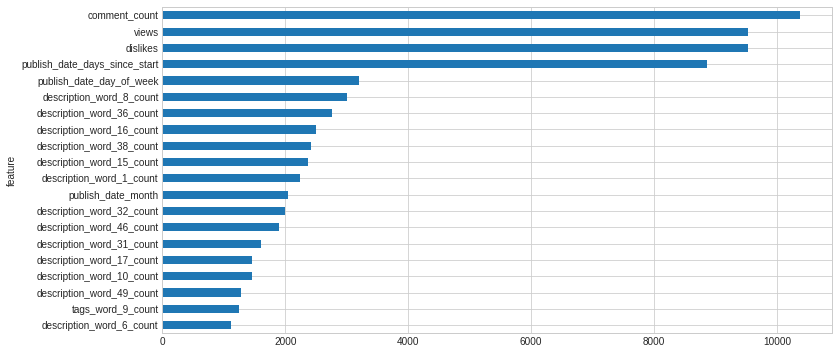

In [158]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_date_text_cols)

# **Final Summary of all the Approaches**

In [159]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Features Used","rmsle_score"]
x.add_row(["Linear Regression", 'Numerical', 949.5])
x.add_row(["Decision Tree Regressor", 'Numerical+Categorical',769.5])
x.add_row(["LGBM Regressor", 'Numerical+Categorical+Date', 665.08])
x.add_row(["LGBM Regressor", 'Numerical+Categorical+Date+Text', 512.8])
print(x)

+-------------------------+---------------------------------+-------------+
|          Model          |          Features Used          | rmsle_score |
+-------------------------+---------------------------------+-------------+
|    Linear Regression    |            Numerical            |    949.5    |
| Decision Tree Regressor |      Numerical+Categorical      |    769.5    |
|      LGBM Regressor     |    Numerical+Categorical+Date   |    665.08   |
|      LGBM Regressor     | Numerical+Categorical+Date+Text |    512.8    |
+-------------------------+---------------------------------+-------------+
